In [82]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_colwidth', 500)
import warnings
import time
warnings.filterwarnings("ignore", category=FutureWarning)

import geopandas as gpd
import shapely
import numpy as np
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator

import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

import nomad.io.base as loader
import nomad.stop_detection.utils as utils
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
#import nomad.stop_detection.ta_dbscan as TADBSCAN
import nomad.stop_detection.dbscan as TADBSCAN
import nomad.stop_detection.grid_based as GRID_BASED # for oracle visits
import nomad.stop_detection.postprocessing as pp

import nomad.visit_attribution as visits
import nomad.filters as filters
import nomad.city_gen as cg

from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, precision_recall_f1_from_minutes
import pdb

Loading the data:

In [2]:
import nomad.city_gen as cg
city = cg.load('../garden-city.pkl')

Create metrics for building size and type and dwell time:

In [3]:
def classify_building_size_from_id(building_id):
    building = city.buildings.get(building_id)
    n_blocks = len(building.blocks)
    if n_blocks == 1:
        return 'small'
    elif 2 <= n_blocks <= 3:
        return 'medium'
    else:
        return 'big'

def classify_building_type_from_id(building_id):
    building = city.buildings.get(building_id)
    return building.building_type

def classify_dwell(duration):
    if duration < 60:
        return 'low'
    elif 60 <= duration <= 180:
        return 'mid'
    else:
        return 'high'

In [4]:
traj_cols = {'user_id':'uid', 'x':'x', 'y':'y', 'timestamp':'timestamp'}
poi_table = gpd.read_file('../garden_city.gpkg')

poi_table = poi_table.rename({'type':'building_type'}, axis=1)
poi_table['building_size'] = poi_table['building_id'].apply(classify_building_size_from_id)

# diaries_df = loader.from_file("../../nomad/data/diaries_raghav", format="parquet", **traj_cols)
diaries_df = loader.from_file("../../nomad/data/diaries", format="parquet", **traj_cols)
diaries_df = diaries_df.rename({'location':'building_id'}, axis=1)
diaries_df = diaries_df.merge(poi_table[['building_id', 'building_size', 'building_type']], on='building_id', how='left')

diaries_df.loc[~diaries_df.building_id.isna(),'dwell_length'] = diaries_df.loc[~diaries_df.building_id.isna(),'duration'].apply(classify_dwell)
diaries_df['building_id'] = diaries_df['building_id']
# sparse_df = loader.from_file("../../nomad/data/sparse_traj_raghav/", format="parquet", **traj_cols)
sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", **traj_cols)

Completeness of trajectory data:

In [5]:
completeness_df = filters.q_stats(sparse_df, traj_cols=traj_cols)

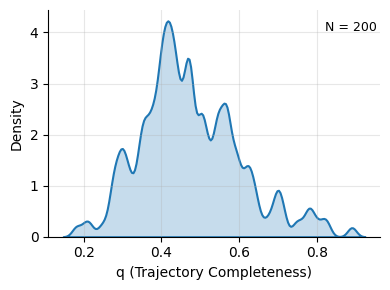

In [6]:
plt.figure(figsize=(4,3))
ax = sns.kdeplot(
    data=completeness_df,
    x="q_stat",
    fill=True,
    linewidth=1.5,
    bw_adjust=0.25
)

# cosmetics
ax.set_xlabel("q (Trajectory Completeness)")
ax.set_ylabel("Density")
ax.grid(True, alpha=0.3)
sns.despine(top=True, right=True)

# annotation (top-right corner in axes coords)
ax.text(
    0.99, 0.95,
    f"N = {len(completeness_df)}",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=9
)

plt.tight_layout()
plt.savefig("q_stat_density.svg", format="svg", bbox_inches="tight")
plt.savefig("q_stat_density.png", format="svg", bbox_inches="tight")
plt.show()

In [7]:
# create boxplots of metrics for different algorithms
def plot_metrics_boxplots(df, metrics,
                          algo_order=None, colors=None,
                          figsize=(24, 5.5), save_path=None):
    # --- normalise inputs -------------------------------------------------
    if algo_order is None:
        # preserve appearance order in the DataFrame
        algo_order = df.algorithm.drop_duplicates().tolist()

    if colors is None:
        cmap = plt.colormaps.get_cmap('tab10')
        colors = {a: cmap(i % cmap.N) for i, a in enumerate(algo_order)}
    else:
        # fill in any missing algorithm colour with the next Tab10 entry
        cmap = plt.colormaps.get_cmap('tab10')
        for i, a in enumerate(algo_order):
            colors.setdefault(a, cmap(i % cmap.N))

    # --- figure -----------------------------------------------------------
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize, sharey=False)

    if len(metrics) == 1:          # when only one metric is passed
        axes = [axes]

    for ax, metric in zip(axes, metrics):
        ax.set_facecolor('#EAEAF2')

        # list of series, one per algorithm
        data = [df.loc[df.algorithm == a, metric].dropna() for a in algo_order]

        bp = ax.boxplot(data,
                        positions=range(len(algo_order)),
                        patch_artist=True,
                        widths=0.4,
                        whis=(5, 95),
                        showfliers=False,
                        medianprops={'color': 'black', 'linewidth': 0.6})

        for box, alg in zip(bp['boxes'], algo_order):
            box.set_facecolor(colors[alg])

        ax.grid(axis='y', color='darkgray', linestyle='--', linewidth=0.8)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.set_title(metric.replace('_', ' ').title(), fontsize=20)
        ax.set_xticks([])
        ax.tick_params(axis='both', labelsize=18)


    # legend
    handles = [plt.matplotlib.patches.Patch(color=colors[a], label=a)
               for a in algo_order]
    fig.legend(handles, algo_order,
               loc='lower center',
               ncol=len(algo_order),
               bbox_to_anchor=(0.5, -0.015),
               fontsize=18)

    plt.subplots_adjust(bottom=0.1, top=0.95)

    if save_path:
        fig.savefig(f'{save_path}.png', dpi=300)
        fig.savefig(f'{save_path}.svg')

    plt.show()


In [8]:
def find_bursts(df, time_col='timestamp', time_thresh=240, user_col='uid'):
    """
    Group consecutive pings into bursts based on temporal gaps.

    Parameters
    ----------
    df : pd.DataFrame
        Trajectory data for a single user or multiple users
    time_col : str
        Name of the timestamp column
    time_thresh : int
        Time threshold in minutes. New burst starts if gap > time_thresh
    user_col : str
        Name of the user ID column (if processing multiple users)

    Returns
    -------
    pd.DataFrame
        Original DataFrame with added 'burst_id' column
    """
    def _find_bursts_single_user(user_df):
        # Sort by timestamp to ensure proper ordering
        user_df = user_df.sort_values(time_col).reset_index(drop=True)

        if len(user_df) == 0:
            return user_df

        # Convert timestamps to datetime if they aren't already
        if not pd.api.types.is_datetime64_any_dtype(user_df[time_col]):
            timestamps = pd.to_datetime(user_df[time_col], unit='s')
        else:
            timestamps = user_df[time_col]

        # Calculate time differences in minutes
        time_diffs = timestamps.diff().dt.total_seconds() / 60

        # Find burst boundaries (where time gap > threshold)
        burst_boundaries = time_diffs > time_thresh

        # Create burst IDs by cumulative sum of boundaries
        burst_ids = burst_boundaries.cumsum()

        # Add burst_id column
        user_df = user_df.copy()
        user_df['burst_id'] = burst_ids

        return user_df

    # If processing single user (no user_col in data or all same user)
    if user_col not in df.columns or df[user_col].nunique() == 1:
        return _find_bursts_single_user(df)

    # Process multiple users
    result_dfs = []

    for user_id, user_df in df.groupby(user_col):
        user_result = _find_bursts_single_user(user_df)

        # Make burst_ids unique by combining with user_id
        user_result['burst_id'] = user_result['burst_id'].astype(str) + f"_{user_id}"

        result_dfs.append(user_result)

    return pd.concat(result_dfs, ignore_index=True)

# Example usage:
def add_bursts_to_trajectory(df, traj_cols, time_thresh=240):
    """
    Convenience wrapper for your specific data structure.
    """
    return find_bursts(
        df, 
        time_col=traj_cols['timestamp'], 
        time_thresh=time_thresh,
        user_col=traj_cols['user_id']
    )

In [9]:
sparse_df = add_bursts_to_trajectory(sparse_df, traj_cols, time_thresh=240)

## Execution for all users

In [94]:
## TRANSFORMATION FUNCTIONS
# Use this for steps that should pass a generic DataFrame through
from operator import truth


def no_op_df(data, **kwargs):
    return data

# Use this for steps that should pass the 'stops' DataFrame through
def no_op_stops(stops, **kwargs):
    return stops

# Pre-processing snippets
def prejoin_oracle_map(data, diary, **kwargs):
    location = visits.oracle_map(data, diary, timestamp='timestamp', location_id='building_id')
    return data.join(location)

# Post-processing snippets
summarize_stops_with_loc = partial(utils.summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols=['building_id'], complete_output=True)

def postjoin_poly_map(data, **kwargs):
    # This is a post-labeling step, before stop creation
    location = visits.point_in_polygon(data=data, poi_table=poi_table, method='majority', data_crs='EPSG:3857',
                                       max_distance=12, cluster_label='cluster', location_id='building_id', x='x', y='y')
    return data.join(location)

# Special fix/adjustment snippets
def rem_overlaps_hdbscan(stops, data_with_clusters, params, **kwargs):
    if pp.invalid_stops(stops):
        # The 'pred' data for remove_overlaps is the data with clusters and POI locations joined
        return pp.remove_overlaps(data_with_clusters, **params, dur_min=5, traj_cols=traj_cols, method='cluster', location_id='building_id')
    return stops

def pad_oracle_stops_long(stops, **kwargs):
    # if len(stops) == 0:
    #     return pd.DataFrame()
    
    return utils.pad_short_stops(stops, pad=5, dur_min=4, start_timestamp='start_timestamp')

# Each row defines the unique workflow for one algorithm
algo_params = pd.DataFrame([
    {
        'algo': 'ta-hdbscan',
        'func': HDBSCAN.hdbscan_labels,
        'params': {'time_thresh': 240, 'min_pts': 2, 'min_cluster_size': 2, 'include_border_points': True},
        'pre_process_func': no_op_df,             # Correct: Passes 'data'
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': rem_overlaps_hdbscan,
    },
    {
        'algo': 'oracle',
        'func': GRID_BASED.grid_based_labels,
        'params': {'time_thresh': 600, 'min_pts': 0, 'location_id': 'building_id'},
        'pre_process_func': prejoin_oracle_map,
        'post_labels_func': no_op_df,             # Correct: Passes 'data'
        'special_fix_func': pad_oracle_stops_long,
    },
    {
        'algo': 'tadbscan_coarse',
        'func': TADBSCAN._temporal_dbscan_labels,
        'params': {'time_thresh': 240, 'min_pts': 2, 'dist_thresh': 30},
        'pre_process_func': no_op_df,             # Correct
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': rem_overlaps_hdbscan,           # Correct
    },
    {
        'algo': 'tadbscan_fine',
        'func': TADBSCAN._temporal_dbscan_labels,
        'params': {'time_thresh': 120, 'min_pts': 3, 'dist_thresh': 20},
        'pre_process_func': no_op_df,             # Correct
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': rem_overlaps_hdbscan,           # Correct
    },
    {
        'algo': 'lachesis_coarse',
        'func': LACHESIS._lachesis_labels,
        'params': {'dt_max': 240, 'delta_roam': 40},
        'pre_process_func': no_op_df,             # Correct: Passes 'data'
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': no_op_stops,           # Correct: Passes 'stops'
    },
    {
        'algo': 'lachesis_fine',
        'func': LACHESIS._lachesis_labels,
        'params': {'dt_max': 120, 'delta_roam': 25},
        'pre_process_func': no_op_df,             # Correct
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': no_op_stops,           # Correct
    }
])

def compute_all_metrics(stops, truth, poi_table, user, algo):
    """
    Calculate all metrics.  One expensive overlap on *raw* stops for
    error rates, a second (gap-filled) overlap for precision/recall.
    """
    
    # Handle case when no stops are detected
    if len(stops) == 0:
        # Create zero metrics for general category
        zero_metrics = {
            'metric_category': 'general',
            'category_value': 'all',
            'total_pred': 0,
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0,
            'missed_fraction': 1.0,  # All truth visits are missed
            'merged_fraction': 0.0,
            'split_fraction': 0.0,
            'user': user,
            'algorithm': algo
        }
        
        results = [zero_metrics]
        
        # Add zero metrics for each category in truth data
        for category in ['building_size', 'building_type', 'dwell_length']:
            if category in truth.columns:
                for val in truth[category].dropna().unique():
                    category_metrics = {
                        'metric_category': category,
                        'category_value': val,
                        'precision': 0.0,
                        'recall': 0.0,
                        'f1': 0.0,
                        'missed_fraction': 1.0,
                        'merged_fraction': 0.0,
                        'split_fraction': 0.0,
                        'user': user,
                        'algorithm': algo
                    }
                    results.append(category_metrics)
        
        return results

    # Original logic continues here for when len(stops) > 0
    stops_err = stops.fillna({'building_id': 'Street'})
    
    overlaps_err = overlapping_visits(
        left=stops_err,
        right=truth.dropna(),
        match_location=False,
        location_id='building_id'
    )

    # 2) PRF overlaps on raw stops (no gap fill at all)
    #    truth we still label Street so they appear in the join step
    stops_prf  = stops.fillna({'building_id': 'Street'})
    truth_prf  = truth.copy().fillna({'building_id': 'Street'})
    
    overlaps_prf = overlapping_visits(
        left=stops_prf,
        right=truth_prf,
        match_location=False,
        location_id='building_id'
    )

    # subset to *matching* POI rows
    prf_overlaps = overlaps_prf[
        overlaps_prf['building_id_left'] == overlaps_prf['building_id_right']
    ]

    # 3) global PRF from minute‐totals
    total_pred  = stops_prf['duration'].sum()
    total_truth = truth_prf['duration'].sum()
    tp          = prf_overlaps['duration'].sum()
    prf1 = precision_recall_f1_from_minutes(total_pred, total_truth, tp)

    # 4) error metrics
    errors = compute_visitation_errors(
        overlaps=overlaps_err,
        true_visits=truth.dropna(),
        location_id='building_id'
    )

    results = [
        {'metric_category': 'general',
         'category_value': 'all',
         'total_pred':total_pred,
         **prf1, **errors}
    ]

    # 5) per-category PRF + error
    for category in ['building_size', 'building_type', 'dwell_length']:
        for val in truth[category].dropna().unique():
            truth_sub = truth[(truth[category] == val)&(truth['building_id']!='Street')]
            # restrict overlaps to any prediction *overlapping* these truth stops
            if category == 'dwell_length':                       # slice by stop itself
                mask_err = overlaps_err['timestamp_right'].isin(truth_sub['timestamp'])
                mask_prf = overlaps_prf['timestamp_right'].isin(truth_sub['timestamp'])
            else:                                                # slice by building
                mask_err = overlaps_err['building_id_right'].isin(truth_sub['building_id'])
                mask_prf = overlaps_prf['building_id_right'].isin(truth_sub['building_id'])


            ov_err = overlaps_err[mask_err]
            ov_prf = overlaps_prf[mask_prf]
            prf_ov = ov_prf[ov_prf['building_id_left'] == ov_prf['building_id_right']]

            # per-category PRF from minutes in these slices
            tp_cat       = prf_ov['duration'].sum()
            pred_cat     = ov_err['duration'].sum()
            truth_cat    = truth_sub['duration'].sum()
            prf1_cat     = precision_recall_f1_from_minutes(pred_cat, truth_cat, tp_cat)

            # per-category error on the same slice of truth

            err_cat = compute_visitation_errors(
                overlaps=ov_err,
                true_visits=truth_sub,
                location_id='building_id'
            )

            results.append({
                'metric_category': category,
                'category_value':   val,
                **prf1_cat, **err_cat
            })

    # tag with user & algo
    for rec in results:
        rec.update({'user': user, 'algorithm': algo})

    return results

### OPTIMIZED LOOP

In [95]:
results_list = []

for user in tqdm(diaries_df.uid.unique(), desc='Processing users'):
    for _, row in algo_params.iterrows():
        
        # PRE
        sparse = sparse_df[sparse_df['uid'] == user].copy()
        truth = diaries_df[diaries_df['uid'] == user].copy()
        processed_sparse = row.pre_process_func(data=sparse, diary=truth)
        
        # ALGORITHM
        start_time = time.time()
        labels = row.func(processed_sparse, **row.params, traj_cols=traj_cols)
        execution_time = time.time() - start_time
        
        # POST
        data_with_clusters = processed_sparse.join(labels)
        data_with_locations = row.post_labels_func(data=data_with_clusters)
        stops = data_with_locations[data_with_locations.cluster != -1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
        stops = row.special_fix_func(stops=stops, data_with_clusters=data_with_locations, params=row.params)

        # METRICS
        metrics = compute_all_metrics(stops, truth, poi_table, user, row.algo)

        # Add execution time to the first metric entry (the 'general' one)
        if metrics:
            metrics[0]['execution_time'] = execution_time
        
        results_list.extend(metrics)

results_df = pd.DataFrame(results_list)

print("Processing Complete!")

Processing users: 100%|██████████| 200/200 [05:33<00:00,  1.67s/it]

Processing Complete!


In [ ]:
# try:
#     results_df = pd.read_csv("results.csv")
# except:
#     results_df.to_csv('results.csv', index=False)

# Per Burst Analysis

In [148]:
diaries_df['end_timestamp'] = diaries_df['timestamp'] + (diaries_df['duration'] * 60)
# diaries_df['end_datetime'] = diaries_df['datetime'] + pd.to_timedelta(diaries_df['duration'], unit='m')

In [149]:
burst_df = sparse_df.groupby(['uid', 'burst_id']).agg(start_timestamp = ('timestamp', 'min'), end_timestamp = ('timestamp', 'max')).reset_index()

In [150]:
results = []

for index, row in burst_df.iterrows():
    start = row['start_timestamp']
    end = row['end_timestamp']
    uid = row['uid']
    burst_id = row['burst_id']
    
    # Updated filtering logic
    diary_burst = diaries_df[
        (diaries_df['uid'] == uid) &
        (diaries_df['end_timestamp'] >= start) &
        (diaries_df['timestamp'] <= end)
    ].copy()
    
    # Clip the timestamps to ensure they fit within the burst range
    diary_burst['timestamp'] = diary_burst['timestamp'].clip(lower=start, upper=end)
    diary_burst['end_timestamp'] = diary_burst['end_timestamp'].clip(lower=start, upper=end)
    
    # Recalculate duration after clipping
    diary_burst['duration'] = (diary_burst['end_timestamp'] - diary_burst['timestamp']) // 60
    
    # Add burst_id
    diary_burst['burst_id'] = burst_id
    results.append(diary_burst)

diary_bursts_df = pd.concat(results).reset_index(drop=True)
diary_bursts_df.drop(columns=['datetime'], errors='ignore', inplace=True)

In [151]:
results_list = []

for burst in tqdm(diary_bursts_df.burst_id.dropna().unique(), desc='Processing bursts'):
    for _, row in algo_params.iterrows():
        
        # Skip if burst is NaN
        if pd.isna(burst):
            continue
        
        # PRE
        sparse = sparse_df[sparse_df['burst_id'] == burst].copy()
        truth = diary_bursts_df[diary_bursts_df['burst_id'] == burst].copy()
        
        # Skip if no data for this burst
        if len(sparse) == 0 or len(truth) == 0:
            continue
            
        processed_sparse = row.pre_process_func(data=sparse, diary=truth)
        
        # ALGORITHM
        start_time = time.time()
        labels = row.func(processed_sparse, **row.params, traj_cols=traj_cols)
        execution_time = time.time() - start_time
        
        # Debug: Check what labels contains
        if labels is None or len(labels) == 0:
            # No labels returned, create empty cluster column
            labels = pd.Series([-1] * len(processed_sparse), index=processed_sparse.index, name='cluster')
        
        # Ensure labels is a Series with name 'cluster'
        if not isinstance(labels, pd.Series):
            labels = pd.Series(labels, index=processed_sparse.index, name='cluster')
        elif labels.name != 'cluster':
            labels = labels.rename('cluster')
        
        # POST
        data_with_clusters = processed_sparse.join(labels)
        
        # Verify cluster column exists
        if 'cluster' not in data_with_clusters.columns:
            # Fallback: add cluster column with all -1 (noise)
            data_with_clusters['cluster'] = -1
        
        data_with_locations = row.post_labels_func(data=data_with_clusters)
        stops = data_with_locations[data_with_locations.cluster != -1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
        
        # if stops.empty:
        #     print("Stops DataFrame is empty. Skipping rem_overlaps_hdbscan.")
        # else:
        #     stops = row.special_fix_func(stops=stops, data_with_clusters=data_with_locations, params=row.params)

        if not stops.empty:
            stops = row.special_fix_func(stops=stops, data_with_clusters=data_with_locations, params=row.params)

        # METRICS
        metrics = compute_all_metrics(stops, truth, poi_table, burst, row.algo)

        # Add execution time to the first metric entry (the 'general' one)
        if metrics:
            metrics[0]['execution_time'] = execution_time
        
        results_list.extend(metrics)

results_df = pd.DataFrame(results_list)

print("Processing Complete!")

Processing bursts: 100%|██████████| 3866/3866 [14:12<00:00,  4.53it/s]


Processing Complete!


# Plotting

In [ ]:
# results_df = bursts_results_df

In [152]:
oracle_df = results_df.loc[results_df.algorithm == 'oracle', ['user', 'category_value','f1']].rename(columns={'f1':'f1_oracle'})
results_df = results_df.merge(oracle_df, on=['user','category_value'],  how='left')
results_df['f1_as_pct_orac'] = 100 * results_df['f1'] / results_df['f1_oracle']

In [153]:
general_metrics_df = results_df[results_df['metric_category'] == 'general'].copy()

In [154]:
general_metrics_df

,metric_category,category_value,total_pred,precision,recall,f1,missed_fraction,merged_fraction,split_fraction,user,algorithm,execution_time,f1_oracle,f1_as_pct_orac
0,general,all,1554.0,0.862291,0.572650,0.688238,0.666667,0.600000,0.00,0_admiring_swirles,ta-hdbscan,0.081107,0.873409,78.799123
9,general,all,1823.0,0.997257,0.776923,0.873409,0.400000,0.111111,0.00,0_admiring_swirles,oracle,0.001002,0.873409,100.000000
18,general,all,1784.0,0.922085,0.702991,0.797769,0.733333,0.250000,0.00,0_admiring_swirles,tadbscan_coarse,0.003453,0.873409,91.339741
27,general,all,1118.0,1.000000,0.477778,0.646617,0.733333,0.000000,0.25,0_admiring_swirles,tadbscan_fine,0.002567,0.873409,74.033682
36,general,all,1742.0,0.770379,0.573504,0.657521,0.666667,0.600000,0.25,0_admiring_swirles,lachesis_coarse,0.002419,0.873409,75.282156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162394,general,all,143.0,1.000000,0.652968,0.790055,0.000000,0.000000,0.00,9_zen_hermann,oracle,0.000231,0.790055,100.000000
162398,general,all,138.0,1.000000,0.630137,0.773109,0.500000,0.000000,0.00,9_zen_hermann,tadbscan_coarse,0.000708,0.790055,97.855086
162402,general,all,138.0,1.000000,0.630137,0.773109,0.500000,0.000000,0.00,9_zen_hermann,tadbscan_fine,0.000652,0.790055,97.855086
162406,general,all,161.0,1.000000,0.735160,0.847368,0.000000,0.000000,0.00,9_zen_hermann,lachesis_coarse,0.000415,0.790055,107.254325


In [155]:
# For each user, find algorithms with F1 better than ta-hdbscan in general_metrics_df

# Filter to only 'general' metrics
general_df = general_metrics_df.copy()

# Get F1 for ta-hdbscan per user
ta_hdbscan_f1 = general_df[general_df['algorithm'] == 'ta-hdbscan'][['user', 'f1']].rename(columns={'f1': 'f1_ta_hdbscan'})

# Merge to compare each algorithm's F1 to ta-hdbscan for the same user
comparison_df = general_df.merge(ta_hdbscan_f1, on='user', how='left')

# Find instances where F1 is better than ta-hdbscan (exclude ta-hdbscan itself)
better_than_ta_hdbscan = comparison_df[
    (comparison_df['algorithm'] != 'ta-hdbscan') &
    (comparison_df['f1'] > comparison_df['f1_ta_hdbscan'])
]

# Show results
better_than_ta_hdbscan[['user', 'algorithm', 'f1', 'f1_ta_hdbscan']]

,user,algorithm,f1,f1_ta_hdbscan
1,0_admiring_swirles,oracle,0.873409,0.688238
2,0_admiring_swirles,tadbscan_coarse,0.797769,0.688238
13,11_admiring_swirles,oracle,0.690409,0.607706
16,11_admiring_swirles,lachesis_coarse,0.690087,0.607706
19,12_admiring_swirles,oracle,0.736842,0.706587
...,...,...,...,...
23171,5_zen_hermann,lachesis_fine,1.000000,0.000000
23179,7_zen_hermann,oracle,0.860952,0.187500
23180,7_zen_hermann,tadbscan_coarse,0.836576,0.187500
23181,7_zen_hermann,tadbscan_fine,0.811133,0.187500


In [156]:
diary_bursts_df[diary_bursts_df['burst_id'] == '7_zen_hermann']

,uid,timestamp,longitude,latitude,x,y,date,duration,building_id,tz_offset,building_size,building_type,dwell_length,end_timestamp,burst_id
33215,zen_hermann,1704457354,-38.318752,36.669245,-4265624.0,4393103.5,2024-01-05,218,w-x6-y8,-14400,medium,work,high,1704470460,7_zen_hermann
33216,zen_hermann,1704470460,NaN,NaN,NaN,NaN,2024-01-05,4,None,-14400,NaN,NaN,NaN,1704470700,7_zen_hermann
33217,zen_hermann,1704470700,-38.317944,36.669515,-4265534.0,4393141.0,2024-01-05,77,p-x13-y11,-14400,big,park,mid,1704475356,7_zen_hermann


In [157]:
len(sparse_df[sparse_df['burst_id'] == '7_zen_hermann'])

12

In [93]:
HDBSCAN.st_hdbscan(sparse_df[sparse_df['burst_id'] == '7_zen_hermann'], time_thresh=240, min_pts=2, min_cluster_size=2, include_border_points=True, traj_cols=traj_cols, complete_output=True)

,cluster,x,y,start_timestamp,ha,diameter,n_pings,end_timestamp,duration,max_gap
0,2,-4.265523e+06,4.393130e+06,1.704473e+09,11.289303,61.261465,4.0,1.704475e+09,32.0,20.0
1,3,-4.265625e+06,4.393100e+06,1.704462e+09,10.838767,11.265678,4.0,1.704467e+09,78.0,58.0
2,4,-4.265620e+06,4.393099e+06,1.704469e+09,13.213687,10.175634,2.0,1.704470e+09,7.0,7.0


In [61]:
LACHESIS.lachesis(sparse_df[sparse_df['burst_id'] == '7_zen_hermann'], dt_max=240, delta_roam=40, traj_cols=traj_cols)

,cluster,x,y,start_timestamp,duration
0,0,-4.265625e+06,4.393100e+06,1.704457e+09,204.0
1,1,-4.265523e+06,4.393130e+06,1.704475e+09,11.0


In [64]:
traj_cols

{'user_id': 'uid', 'x': 'x', 'y': 'y', 'timestamp': 'timestamp'}

In [65]:
TADBSCAN._temporal_dbscan_labels(sparse_df[sparse_df['burst_id'] == '7_zen_hermann'], time_thresh=240, min_pts=2, dist_thresh=30, traj_cols=traj_cols)

188658    0
188659    0
188660    0
188661    0
188662    0
188663    0
188664    0
188665    0
188666   -1
188667    1
188668    1
188669    1
Name: cluster, dtype: int64

In [ ]:
general_metrics_df

In [158]:
# BOOTSTRAPPING GROUPBY
agg_keys = ['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']
ua = general_metrics_df.groupby(['user','algorithm'], as_index=False)[agg_keys].median()
users = ua['user'].unique()
output = []
for _ in range(2000):
    draw = np.random.choice(users, size=len(users), replace=True)
    bs = ua[ua.user.isin(draw)]
    output.append(bs.groupby('algorithm', as_index=False)[agg_keys].median())
metrics_bootstrap_df = pd.concat(output, ignore_index=True)

### Plot boostrapped per-stop metrics for general trajectory

In [159]:
# base colors for coarse versions
shade = lambda c,f=0.6: mcolors.to_hex(tuple(f*x for x in mcolors.to_rgb(c)))
raw = {'oracle':'royalblue','ta-hdbscan':'darkorange','lachesis_coarse':'palevioletred','tadbscan_coarse':'limegreen'}

_base = {k:mcolors.to_hex(mcolors.to_rgb(v)) for k,v in raw.items()}

algo_order = ['oracle','ta-hdbscan','lachesis_coarse','tadbscan_coarse','lachesis_fine', 'tadbscan_fine']
colors = {a:(_base[a] if a in _base else shade(_base[a.split('_')[0]+'_coarse'])) for a in algo_order}

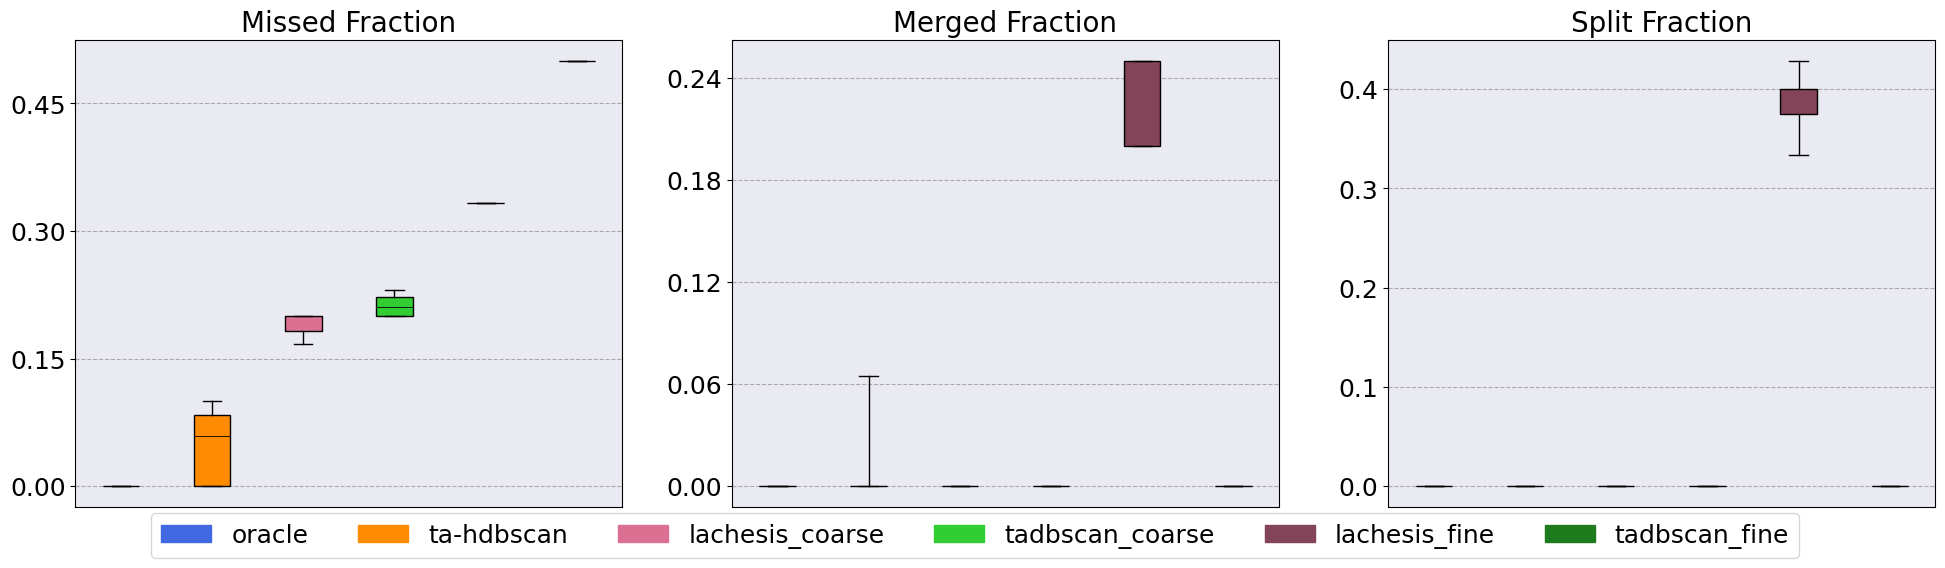

In [160]:
# metrics = ['missed_fraction', 'merged_fraction', 'split_fraction', 'precision', 'recall', 'f1']
metrics = ['missed_fraction', 'merged_fraction', 'split_fraction']

plot_metrics_boxplots(metrics_bootstrap_df, metrics, algo_order=algo_order, colors=colors, save_path='errors_per_stop')

### Plot of F1 scores for each q

In [161]:
def min_neighbor_distance(df, use_lon_lat, traj_cols):
    times = df[traj_cols['timestamp']].values
    
    if use_lon_lat:
        coords = np.radians(df[[traj_cols['latitude'], traj_cols['longitude']]].values)
        # Vectorized haversine
        lat1, lon1 = coords[:, 0], coords[:, 1]
        lat2, lon2 = coords[:, 0][:, None], coords[:, 1][:, None]
        
        dlat = lat1 - lat2
        dlon = lon1 - lon2
        a = np.sin(dlat/2)**2 + np.cos(lat2) * np.cos(lat1) * np.sin(dlon/2)**2
        dist_matrix = 2 * 6371000 * np.arcsin(np.sqrt(a))  # Earth radius in meters
    else:
        coords = df[[traj_cols['x'], traj_cols['y']]].values
        # Vectorized Euclidean distance
        diff = coords[:, None, :] - coords[None, :, :]
        dist_matrix = np.sqrt(np.sum(diff**2, axis=2))
    
    # Set diagonal to infinity
    np.fill_diagonal(dist_matrix, np.inf)
    
    # Find minimum distance for each point
    min_distances = np.min(dist_matrix, axis=1)
    
    return pd.DataFrame({
        'timestamp': times,
        'min_distance': min_distances
    })

def kth_neighbor_distance(df, use_lon_lat, traj_cols, k=1):
    """
    Compute the k-th closest distance for each point in the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing trajectory data.
    use_lon_lat : bool
        Whether to use latitude/longitude (haversine) or Cartesian coordinates.
    traj_cols : dict
        Dictionary mapping column names for 'x', 'y', 'timestamp', etc.
    k : int
        The k-th closest distance to compute (default is 1, i.e., the nearest neighbor).

    Returns
    -------
    pd.DataFrame
        DataFrame with 'timestamp' and 'kth_distance' columns.
    """
    times = df[traj_cols['timestamp']].values

    if use_lon_lat:
        coords = np.radians(df[[traj_cols['latitude'], traj_cols['longitude']]].values)
        # Vectorized haversine
        lat1, lon1 = coords[:, 0], coords[:, 1]
        lat2, lon2 = coords[:, 0][:, None], coords[:, 1][:, None]

        dlat = lat1 - lat2
        dlon = lon1 - lon2
        a = np.sin(dlat / 2) ** 2 + np.cos(lat2) * np.cos(lat1) * np.sin(dlon / 2) ** 2
        dist_matrix = 2 * 6371000 * np.arcsin(np.sqrt(a))  # Earth radius in meters
    else:
        coords = df[[traj_cols['x'], traj_cols['y']]].values
        # Vectorized Euclidean distance
        diff = coords[:, None, :] - coords[None, :, :]
        dist_matrix = np.sqrt(np.sum(diff ** 2, axis=2))

    # Set diagonal to infinity to exclude self-distance
    np.fill_diagonal(dist_matrix, np.inf)

    # Find the k-th smallest distance for each point
    kth_distances = np.partition(dist_matrix, k - 1, axis=1)[:, k - 1]

    return pd.DataFrame({
        'timestamp': times,
        'kth_distance': kth_distances
    })


def min_neighbor_density_stats(df, use_lon_lat, traj_cols, key='user_id'):
    """
    For each user, compute 1/mean(min_distance) from their trajectory.

    Returns
    -------
    pd.DataFrame with columns ['user_id', 'min_neighbor_density']
    """
    results = []
    u_key = traj_cols['user_id'] if key == 'user_id' else key
    for user, group in tqdm(df.groupby(u_key), desc='Computing min neighbor density'):
        min_dist_df = min_neighbor_distance(group, use_lon_lat, traj_cols)
        # min_dist_df = kth_neighbor_distance(group, use_lon_lat, traj_cols, k=2)
        mean_min_dist = np.mean(min_dist_df['min_distance'].dropna())
        # mean_min_dist = np.mean(min_dist_df['kth_distance'].dropna())
        density = 1.0 / mean_min_dist if mean_min_dist > 0 else 0.0
        # density = mean_min_dist
        results.append({'user_id': user, 'min_neighbor_density': density})
    return pd.DataFrame(results)


In [162]:
traj_cols = {'user_id':'uid', 'x':'x', 'y':'y', 'timestamp':'timestamp'}

average_min_distance = min_neighbor_density_stats(sparse_df, use_lon_lat=False, traj_cols=traj_cols, key='burst_id')
# average_min_distance = min_neighbor_density_stats(sparse_df, use_lon_lat=False, traj_cols=traj_cols)

Computing min neighbor density: 100%|██████████| 3866/3866 [00:01<00:00, 2423.22it/s]


In [163]:
average_min_distance

,user_id,min_neighbor_density
0,0_admiring_swirles,0.125170
1,0_admiring_tereshkova,0.137170
2,0_adoring_almeida,0.152214
3,0_adoring_chandrasekhar,0.280463
4,0_adoring_heyrovsky,0.090162
...,...,...
3861,9_youthful_meninsky,0.146409
3862,9_youthful_swanson,0.179268
3863,9_youthful_thompson,1.415421
3864,9_youthful_wilson,0.000000


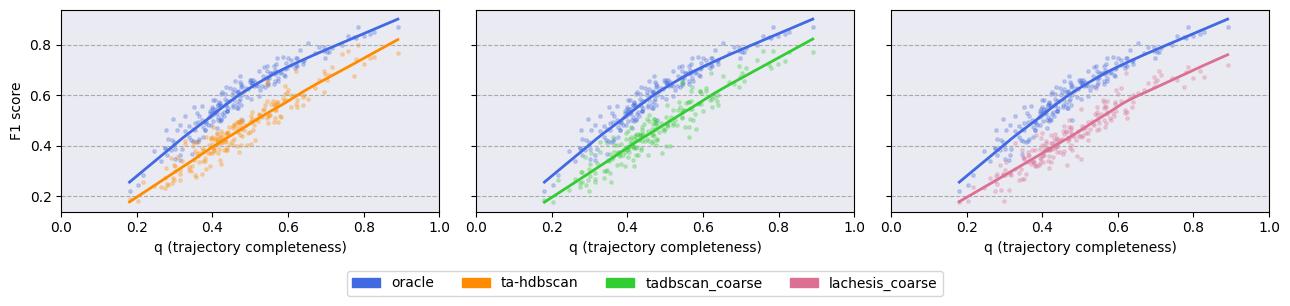

In [128]:
def plot_f1_vs_q(general_df, completeness_df, save_path=None):
    """Three-panel plot: oracle vs hdbscan / tadbscan_coarse / lachesis_coarse."""

    # --- palette & comparison pairs --------------------------------------
    pairs  = [('oracle', 'ta-hdbscan'),
              ('oracle', 'tadbscan_coarse'),
              ('oracle', 'lachesis_coarse')]

    colors = {'oracle': 'royalblue',
              'ta-hdbscan': 'darkorange',
              'tadbscan_coarse': 'limegreen',
              'lachesis_coarse': 'palevioletred'}

    # --- merge: just rename q_stat -> q ----------------------------------
    comp = completeness_df.rename(columns={'q_stat': 'q'})[['uid', 'q']]
    df   = general_df.merge(comp, left_on='user', right_on='uid', how='left')

    # --- figure ----------------------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(13, 2.75), sharey=True)

    for ax, (a1, a2) in zip(axes, pairs):
        ax.set_facecolor('#EAEAF2')            # seaborn-like bg

        for alg in (a1, a2):
            sub = df[df.algorithm == alg].dropna(subset=['q']).sort_values('q')
            if sub.empty:
                continue
            sm  = lowess(sub['f1'], sub['q'], frac=0.6)
            ax.plot(sm[:, 0], sm[:, 1], color=colors[alg], lw=2)
            ax.scatter(sub['q'], sub['f1'], color=colors[alg], s=6, alpha=0.25)

        ax.grid(axis='y', color='darkgray', linestyle='--', lw=0.8)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.set_xlabel("q (trajectory completeness)")
        ax.set_xticks(np.linspace(0, 1, 6))
        ax.tick_params(axis='both', labelsize=10)

    axes[0].set_ylabel("F1 score")

    # --- single legend ---------------------------------------------------
    handles = [plt.matplotlib.patches.Patch(color=colors[a], label=a) for a in colors]
    fig.legend(handles, colors, loc='lower center',
               ncol=len(colors), bbox_to_anchor=(0.5, -0.12))

    plt.tight_layout()

    if save_path:
        fig.savefig(f"{save_path}.png", dpi=300, bbox_inches='tight')
        fig.savefig(f"{save_path}.svg", bbox_inches='tight')

    plt.show()

plot_f1_vs_q(general_metrics_df, completeness_df,
             save_path="f1_vs_q")

In [164]:
def plot_f1_vs_density(general_df, average_density_df, save_path=None):
    """Three-panel plot showing F1 score vs density: oracle vs hdbscan / tadbscan_coarse / lachesis_coarse."""

    # --- palette & comparison pairs --------------------------------------
    pairs  = [('oracle', 'ta-hdbscan'),
              ('oracle', 'tadbscan_coarse'),
              ('oracle', 'lachesis_coarse')]

    colors = {'oracle': 'royalblue',
              'ta-hdbscan': 'darkorange',
              'tadbscan_coarse': 'limegreen',
              'lachesis_coarse': 'palevioletred'}

    # --- merge: rename user_id -> uid for consistent joining -------------
    density_df = average_density_df.rename(columns={'user_id': 'uid', 'avg_density': 'density'})
    df = general_df.merge(density_df, left_on='user', right_on='uid', how='left')

    # --- figure ----------------------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(13, 2.75), sharey=True)

    for ax, (a1, a2) in zip(axes, pairs):
        ax.set_facecolor('#EAEAF2')            # seaborn-like bg

        for alg in (a1, a2):
            sub = df[df.algorithm == alg].dropna(subset=['density']).sort_values('density')
            if sub.empty:
                continue
            sm  = lowess(sub['f1_as_pct_orac'], sub['density'], frac=0.6)
            ax.plot(sm[:, 0], sm[:, 1], color=colors[alg], lw=2)
            ax.scatter(sub['density'], sub['f1_as_pct_orac'], color=colors[alg], s=6, alpha=0.25)

        ax.grid(axis='y', color='darkgray', linestyle='--', lw=0.8)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.set_xlabel("Average Density")
        
        # Use log scale for x-axis since density values can vary widely
        ax.set_xscale('log')
        ax.tick_params(axis='both', labelsize=18)

    axes[0].set_ylabel("F1 score as % of Oracle")

    # --- single legend ---------------------------------------------------
    handles = [plt.matplotlib.patches.Patch(color=colors[a], label=a) for a in colors]
    fig.legend(handles, colors, loc='lower center',
               ncol=len(colors), bbox_to_anchor=(0.5, -0.12))

    plt.tight_layout()

    if save_path:
        fig.savefig(f"{save_path}.png", dpi=300, bbox_inches='tight')
        fig.savefig(f"{save_path}.svg", bbox_inches='tight')

    plt.show()

In [183]:
def plot_f1_vs_density_single(general_df, average_min_distance, save_path=None):
    """Single panel plot showing F1 score vs density for all algorithm variants."""

    # --- palette & algorithm list ----------------------------------------
    algos = ['ta-hdbscan', 'tadbscan_coarse', 'lachesis_coarse', 'tadbscan_fine', 'lachesis_fine']
    
    # Define base colors
    base_colors = {
        'ta-hdbscan': 'darkorange',
        'tadbscan_coarse': 'limegreen',
        'lachesis_coarse': 'palevioletred',
        'tadbscan_fine': 'lightgreen',
        'lachesis_fine': 'lightpink'
    }
    
    # Create shaded versions for the fine-tuned variants
    shade = lambda c, f=0.6: mcolors.to_hex(tuple(f*x for x in mcolors.to_rgb(c)))
    colors = {}
    
    for algo in algos:
        if algo in base_colors:
            colors[algo] = base_colors[algo]
        else:
            # For fine variants, use shaded version of corresponding coarse color
            base_algo = algo.split('_')[0] + '_coarse'
            colors[algo] = shade(base_colors[base_algo])

    # --- merge: rename user_id -> uid for consistent joining -------------
    density_df = average_min_distance.rename(columns={'user_id': 'uid', 'min_neighbor_density': 'density'})
    df = general_df.merge(density_df, left_on='user', right_on='uid', how='left')

    # --- figure ----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_facecolor('#EAEAF2')  # seaborn-like bg

    for alg in algos:
        sub = df[df.algorithm == alg].dropna(subset=['density']).sort_values('density')
        if sub.empty:
            continue
        
        # sm = lowess(sub['f1_as_pct_orac'], sub['density'], frac=0.6)
        sm = lowess(sub['f1'], sub['density'], frac=0.5)
        ax.plot(sm[:, 0], sm[:, 1], color=colors[alg], lw=2, label=alg)
        # ax.scatter(sub['density'], sub['f1_as_pct_orac'], color=colors[alg], s=6, alpha=0.25)
        ax.scatter(sub['density'], sub['f1'], color=colors[alg], s=6, alpha=0.05)

    ax.grid(axis='y', color='darkgray', linestyle='--', lw=0.8)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.set_xlabel("Average Density")
    # ax.set_ylabel("F1 Score as % of Oracle")
    ax.set_ylabel("F1 Score")
    
    # Use log scale for x-axis since density values can vary widely
    # ax.set_xlim(0.15,0.25)
    ax.set_xlim(0, 0.4)
    ax.tick_params(axis='both', labelsize=10)

    # Create patches for legend
    handles = [plt.matplotlib.patches.Patch(color=colors[a], label=a) for a in algos]
    
    # Add centered legend at bottom
    fig.legend(handles, algos, loc='lower center', 
               ncol=len(algos), bbox_to_anchor=(0.5, -0.12))

    plt.subplots_adjust(bottom=0.2)  # Make room for the legend
    plt.tight_layout()

    if save_path:
        fig.savefig(f"{save_path}.png", dpi=300, bbox_inches='tight')
        fig.savefig(f"{save_path}.svg", bbox_inches='tight')

    plt.show()

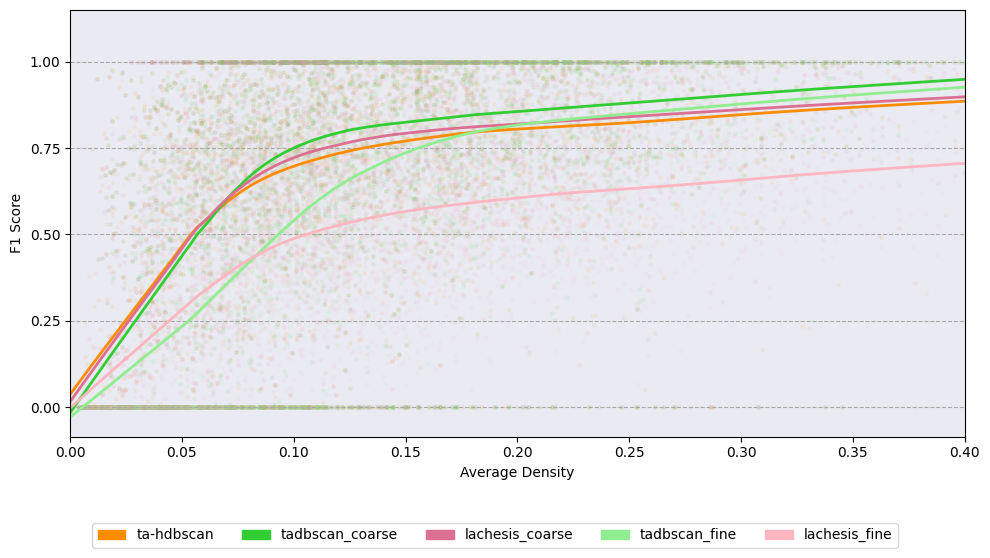

In [184]:
plot_f1_vs_density_single(general_metrics_df, average_min_distance, 
                         save_path="f1_vs_degree_single")

### Metrics for each category value

In [69]:
# for each user, algo, and category_value
if 'f1_as_pct_orac' not in results_df:
    oracle_df = results_df.loc[results_df.algorithm == 'oracle', ['user', 'category_value','f1']].rename(columns={'f1':'f1_oracle'})
    results_df = results_df.merge(oracle_df, on=['user','category_value'],  how='left')
    results_df['f1_as_pct_orac'] = 100 * results_df['f1'] / results_df['f1_oracle']

In [70]:
#table_results = results_df.loc[results_df.algorithm.isin(['ta-hdbscan', 'lachesis_coarse','tadbscan_coarse', 'lachesis_fine', 'tadbscan_fine'])]#
table_results = results_df.loc[results_df.algorithm.isin(['ta-hdbscan', 'lachesis_coarse','tadbscan_coarse'])]
table_results = table_results.loc[~table_results.category_value.isin(['all', 'big', 'medium', 'small', 'mid'])]
table_results = table_results.groupby(['metric_category', 'category_value', 'algorithm'], as_index=True)[['f1', 'f1_as_pct_orac']].median().round(2)
table_results.to_csv('results_by_category.csv', index=True)
table_results

f1  f1_as_pct_orac
metric_category category_value algorithm                            
building_type   home           lachesis_coarse  0.48           79.11
                               ta-hdbscan       0.49           78.84
                               tadbscan_coarse  0.49           78.15
                park           lachesis_coarse  0.20           68.80
                               ta-hdbscan       0.26           90.98
                               tadbscan_coarse  0.21           77.33
                retail         lachesis_coarse  0.18           75.34
                               ta-hdbscan       0.16           69.51
                               tadbscan_coarse  0.14           61.47
                work           lachesis_coarse  0.38           91.88
                               ta-hdbscan       0.39           93.21
                               tadbscan_coarse  0.36           87.80
dwell_length    high           lachesis_coarse  0.46           81.57
                               ta-hdbscan       0.47           82.39
                               tadbscan_coarse  0.46           80.08
                low            lachesis_coarse  0.16           70.57
                               ta-hdbscan       0.16           67.71
                               tadbscan_coarse  0.14           57.17